# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from scipy.ndimage import gaussian_filter, median_filter
from scipy.optimize import curve_fit
from string import ascii_uppercase
from utils import plot_side_by_side
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

# Background Extraction

In [2]:
def remove_background(image, background, offset=0):
    diff_image = image.astype("int16") - background.astype("int16") + offset
    diff_image = np.where(diff_image < 0, 0, diff_image)
    return diff_image

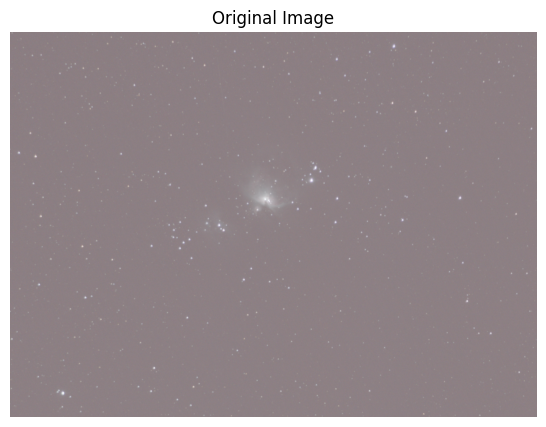

In [3]:
image_path = "./data/orion.png"


image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plot_side_by_side([image], ["Original Image"])

In [4]:
def treshold_image(image, quantile_threshold):
    input_image = image.copy()
    
    filtered_image = gaussian_filter(input_image, sigma=3)
    gray_image = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY)
    threshold = np.quantile(gray_image.flatten(), quantile_threshold)
    _, tresholded_image = cv2.threshold(gray_image, threshold, 255, 0)
    return tresholded_image

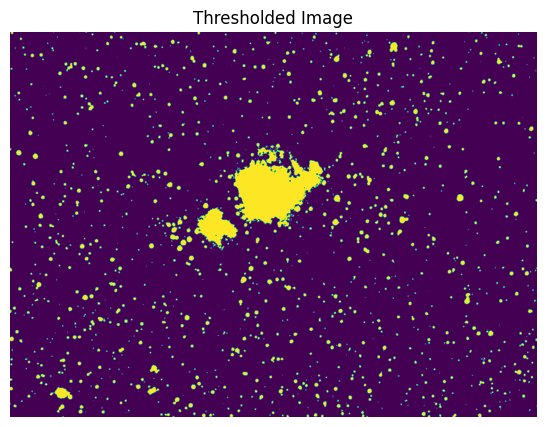

In [5]:
# Treshold image
tresholded_image = treshold_image(image, 0.90)
plot_side_by_side([tresholded_image], ["Thresholded Image"])

In [10]:
def get_samples(
    image, samples_per_line, quantile_threshold=0.90, border_offset=20, sample_offset=10
):
    annotated_image = image.copy()

    tresholded_image = treshold_image(image, quantile_threshold)
    dilated_image = cv2.dilate(
        tresholded_image, np.ones((5, 5), np.uint8), iterations=1
    )

    height, width = image.shape[0], image.shape[1]
    horizontal_sample_coordinates = np.linspace(
        0 + border_offset, width - border_offset, samples_per_line, dtype=int
    )
    vertical_sample_coordinates = np.linspace(
        0 + border_offset, height - border_offset, 10, dtype=int
    )

    samples = []
    for x in horizontal_sample_coordinates:
        for y in vertical_sample_coordinates:
            sample = find_valid_sample(dilated_image, x, y, sample_offset)
            if sample:
                samples.append(sample)
                annotated_image = cv2.circle(
                    annotated_image,
                    (sample[0], sample[1]),
                    radius=10,
                    color=(0, 255, 0),
                    thickness=2,
                )

    return np.array(samples), annotated_image


def find_valid_sample(image, x, y, sample_offset):
    sample_offsets = [
        (0, 0),
        (0, -sample_offset),
        (0, sample_offset),
        (-sample_offset, 0),
        (sample_offset, 0),
    ]
    for dx, dy in sample_offsets:
        if image[y + dy, x + dx] == 0:
            return [x + dx, y + dy]

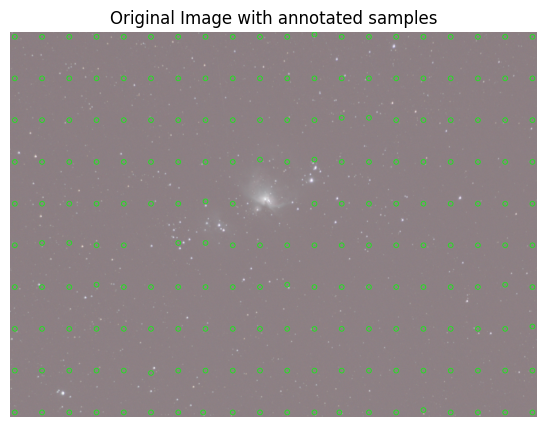

In [11]:
# Generate sample data
samples, annotated_image = get_samples(image, 20)
plot_side_by_side([annotated_image], ["Original Image with annotated samples"])

In [12]:
def extract_pixel_data(samples, image):
    x, y = samples.T
    if image.ndim == 3:
        pixel_values = image[y, x]
    else:
        pixel_values = image[y, x][:, np.newaxis]
    return np.hstack([samples, pixel_values])

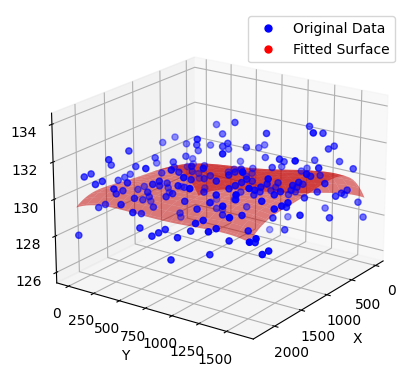

Coefficients:
A = -0.000
B = -0.000
C = 0.000
D = -0.000
E = 0.000
F = -0.000
G = 0.008
H = 0.004
I = -0.000
J = 126.918


In [13]:
# Convert RGB image to grayscale for simplicity
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
pixel_data_array = extract_pixel_data(samples, gray_image)
x, y, z = pixel_data_array.T


# Define the 4th order polynomial funtion
def poly_surface(xy, A, B, C, D, E, F, G, H, I, J):
    x, y = xy
    return (
        (A * x**4)
        + (B * y**4)
        + (C * x**3)
        + (D * x**2)
        + (E * y**3)
        + (F * y**2)
        + (G * x)
        + (H * y)
        + (I * x * y)
        + J
    )


# Fit the data to the 4th order polynomial surface
coefficients, _ = curve_fit(poly_surface, (x, y), z)

# Evaluate the fitted surface at new points
x_new = np.arange(0, max(x), 1, dtype=float)
y_new = np.arange(0, max(y), 1, dtype=float)

x_mesh, y_mesh = np.meshgrid(x_new, y_new)
z_fit = poly_surface((x_mesh, y_mesh), *coefficients)

# Plot the original data and the fitted surface
original_data_color = "b"
fitted_surface_color = "r"
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(x, y, z, label="Original Data", color=original_data_color)
ax.view_init(elev=20.0, azim=35, roll=0)
surface = ax.plot_surface(
    x_mesh,
    y_mesh,
    z_fit,
    alpha=0.5,
    rstride=100,
    cstride=100,
    color=fitted_surface_color,
    label="Fitted Surface",
)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
# Create custom legend
legend_elements = [
    Line2D(
        [0],
        [0],
        color=original_data_color,
        marker="o",
        linestyle="None",
        markersize=5,
        label="Original Data",
    ),
    Line2D(
        [0],
        [0],
        color=fitted_surface_color,
        marker="o",
        linestyle="None",
        markersize=5,
        label="Fitted Surface",
    ),
]
ax.legend(handles=legend_elements)

plt.show()

# Display the coefficients
print("Coefficients:")
for i, j in zip(coefficients, ascii_uppercase):
    print(f"{j} = {i:.3f}")

In [14]:
def compute_background_estimation(samples, image):
    pixel_data = extract_pixel_data(samples, image)

    height, width, _ = image.shape
    x, y, r, g, b = pixel_data.T
    x_img = np.arange(0, width, 1, dtype=float)
    y_img = np.arange(0, height, 1, dtype=float)
    x_img, y_img = np.meshgrid(x_img, y_img)
    background_estimation = []
    for z in [r, g, b]:
        coefficients, _ = curve_fit(poly_surface, (x, y), z)
        z_fit = poly_surface((x_img, y_img), *coefficients).astype(np.uint8)
        background_estimation.append(z_fit)

    background_estimation = np.stack(background_estimation, axis=-1)
    return background_estimation

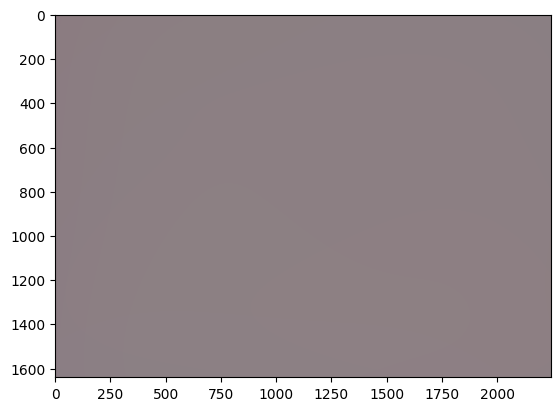

In [15]:
background_estimation = compute_background_estimation(samples, image)
plt.imshow(background_estimation);

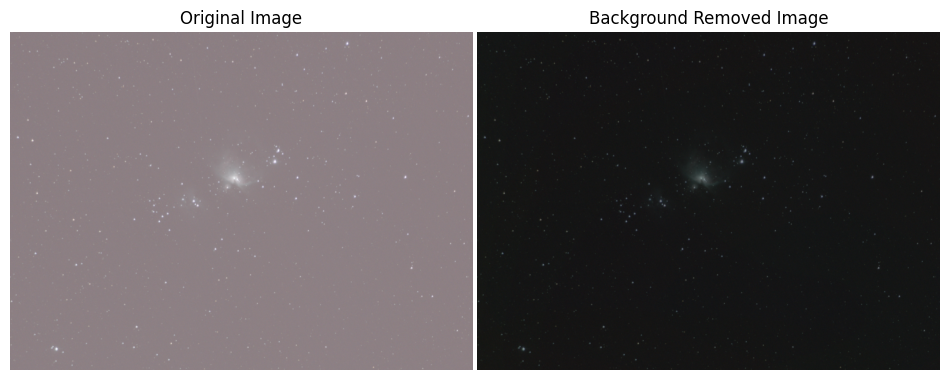

In [16]:
background_removed_image = remove_background(image, background_estimation, 20)

plot_side_by_side(
    [image, background_removed_image],
    ["Original Image", "Background Removed Image"],
    figsize=(12, 6),
)